## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [131]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [132]:
# (re-)load layers
%run modules.ipynb

<>:3: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3092293347.py:3: SyntaxWarning: invalid escape sequence '\g'
  Implements linear transform of input y = \gamma * x + \beta


# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

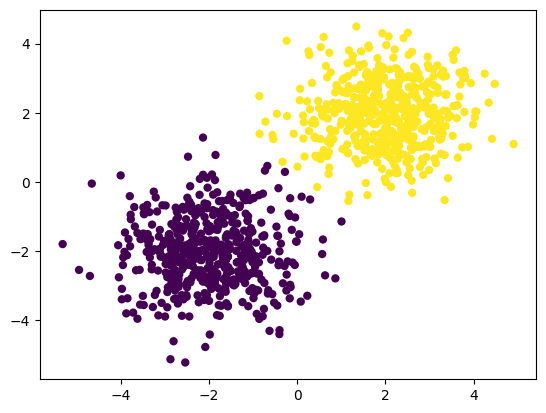

In [133]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [134]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [135]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [136]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

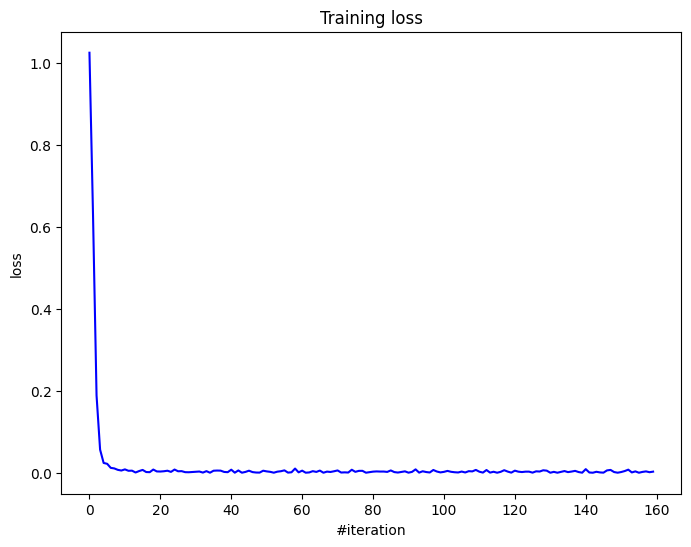

Current loss: 0.002656


In [137]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [138]:
def load_dataset(flatten=False):

    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    y = y.astype(int)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=10000,
        random_state=42,
        stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=0.2,
        random_state=42,
        stratify=y_temp
    )

    X_train = X_train.astype(np.float32) / 255.0
    X_val = X_val.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0

    if flatten:
        X_train = X_train.reshape([-1, 28**2])
        X_val = X_val.reshape([-1, 28**2])
        X_test = X_test.reshape([-1, 28**2])

    return X_train, y_train, X_val, y_val, X_test, y_test

One-hot encode the labels first.

In [139]:
# Your code goes here. ################################################
def one_hot_encode(labels, num_classes=10):
    encoded_labels = np.zeros((labels.shape[0], num_classes))
    encoded_labels[np.arange(labels.shape[0]), labels] = 1.0
    return encoded_labels

Y_train = one_hot_encode(y_train, 10)
Y_val = one_hot_encode(y_val, 10)
Y_test = one_hot_encode(y_test, 10)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [140]:
# Your code goes here. ################################################
def train_and_get_loss_history(activation_class, net_name, optimizer_func, optimizer_config, n_epoch=10, batch_size=128):

    net = Sequential()
    net.add(Linear(784, 128))
    net.add(activation_class())
    net.add(Linear(128, 10))
    net.add(LogSoftMax())

    criterion = ClassNLLCriterion()
    optimizer_state = {}

    epoch_losses = []

    for i in range(n_epoch):
        batch_losses = []
        for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
            net.zeroGradParameters()

            # Forward pass
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward pass
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer_func(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)

            batch_losses.append(loss)

        mean_epoch_loss = np.mean(batch_losses)
        epoch_losses.append(mean_epoch_loss)

    return epoch_losses

optimizer_config_sgd = {'learning_rate': 1e-4, 'momentum': 0.9}

losses_relu = train_and_get_loss_history(ReLU, 'ReLU', sgd_momentum, optimizer_config_sgd)
losses_elu = train_and_get_loss_history(ELU, 'ELU', sgd_momentum, optimizer_config_sgd)
losses_leaky = train_and_get_loss_history(LeakyReLU, 'LeakyReLU', sgd_momentum, optimizer_config_sgd)
losses_softplus = train_and_get_loss_history(SoftPlus, 'SoftPlus', sgd_momentum, optimizer_config_sgd)

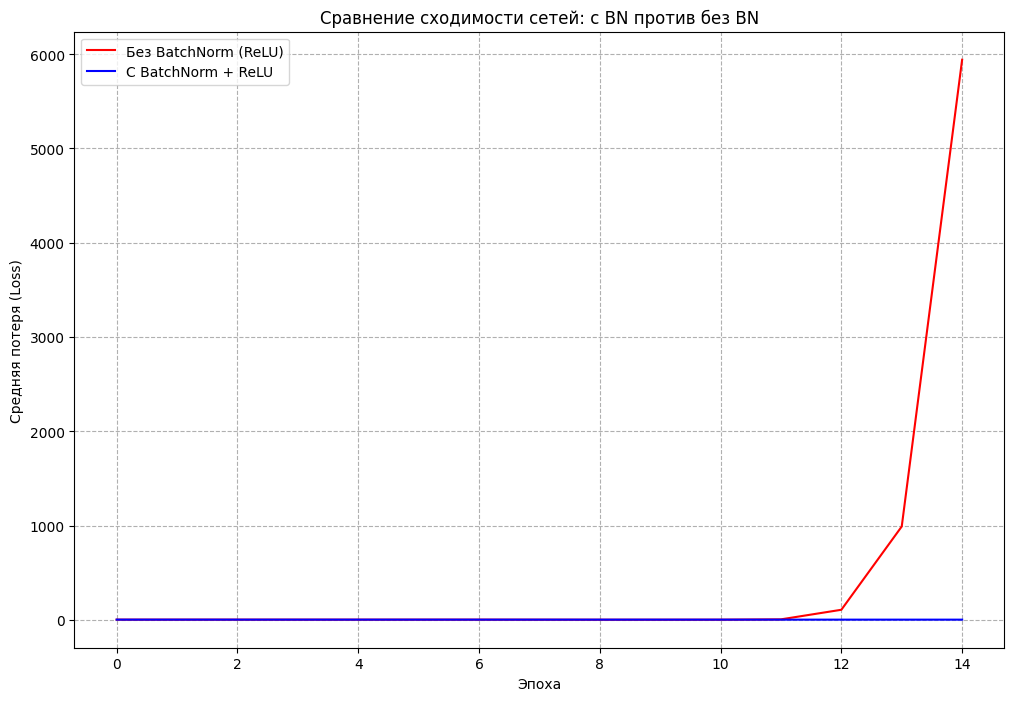

In [141]:
def train_and_get_loss_history(net_builder_func, net_name, optimizer_func, optimizer_config, n_epoch=10, batch_size=128):

    net = net_builder_func()
    criterion = ClassNLLCriterion()
    optimizer_state = {}

    epoch_losses = []

    for i in range(n_epoch):
        batch_losses = []
        for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
            net.zeroGradParameters()

            # Forward pass
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward pass
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer_func(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)

            batch_losses.append(loss)

        mean_epoch_loss = np.mean(batch_losses)
        epoch_losses.append(mean_epoch_loss)

    net.evaluate()
    return epoch_losses

def build_net_without_bn():
    net = Sequential()
    net.add(Linear(784, 128))
    net.add(ReLU())
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

def build_net_with_bn():
    net = Sequential()
    net.add(Linear(784, 128))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(128))
    net.add(ReLU())
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

optimizer_config_sgd = {'learning_rate': 1e-4, 'momentum': 0.9}
n_epochs_compare = 15

losses_no_bn = train_and_get_loss_history(
    build_net_without_bn, 'Без BatchNorm', sgd_momentum, optimizer_config_sgd, n_epoch=n_epochs_compare
)

losses_with_bn = train_and_get_loss_history(
    build_net_with_bn, 'С BatchNorm', sgd_momentum, optimizer_config_sgd, n_epoch=n_epochs_compare
)

plt.figure(figsize=(12, 8))

plt.plot(losses_no_bn, label='Без BatchNorm (ReLU)', color='red')
plt.plot(losses_with_bn, label='С BatchNorm + ReLU', color='blue')

plt.title("Сравнение сходимости сетей: с BN против без BN")
plt.xlabel("Эпоха")
plt.ylabel("Средняя потеря (Loss)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

Батч-нормализация обеспечивает значительно лучшую стабильность обучения и позволяет сети сходиться, в то время как сеть без нее становится нестабильной

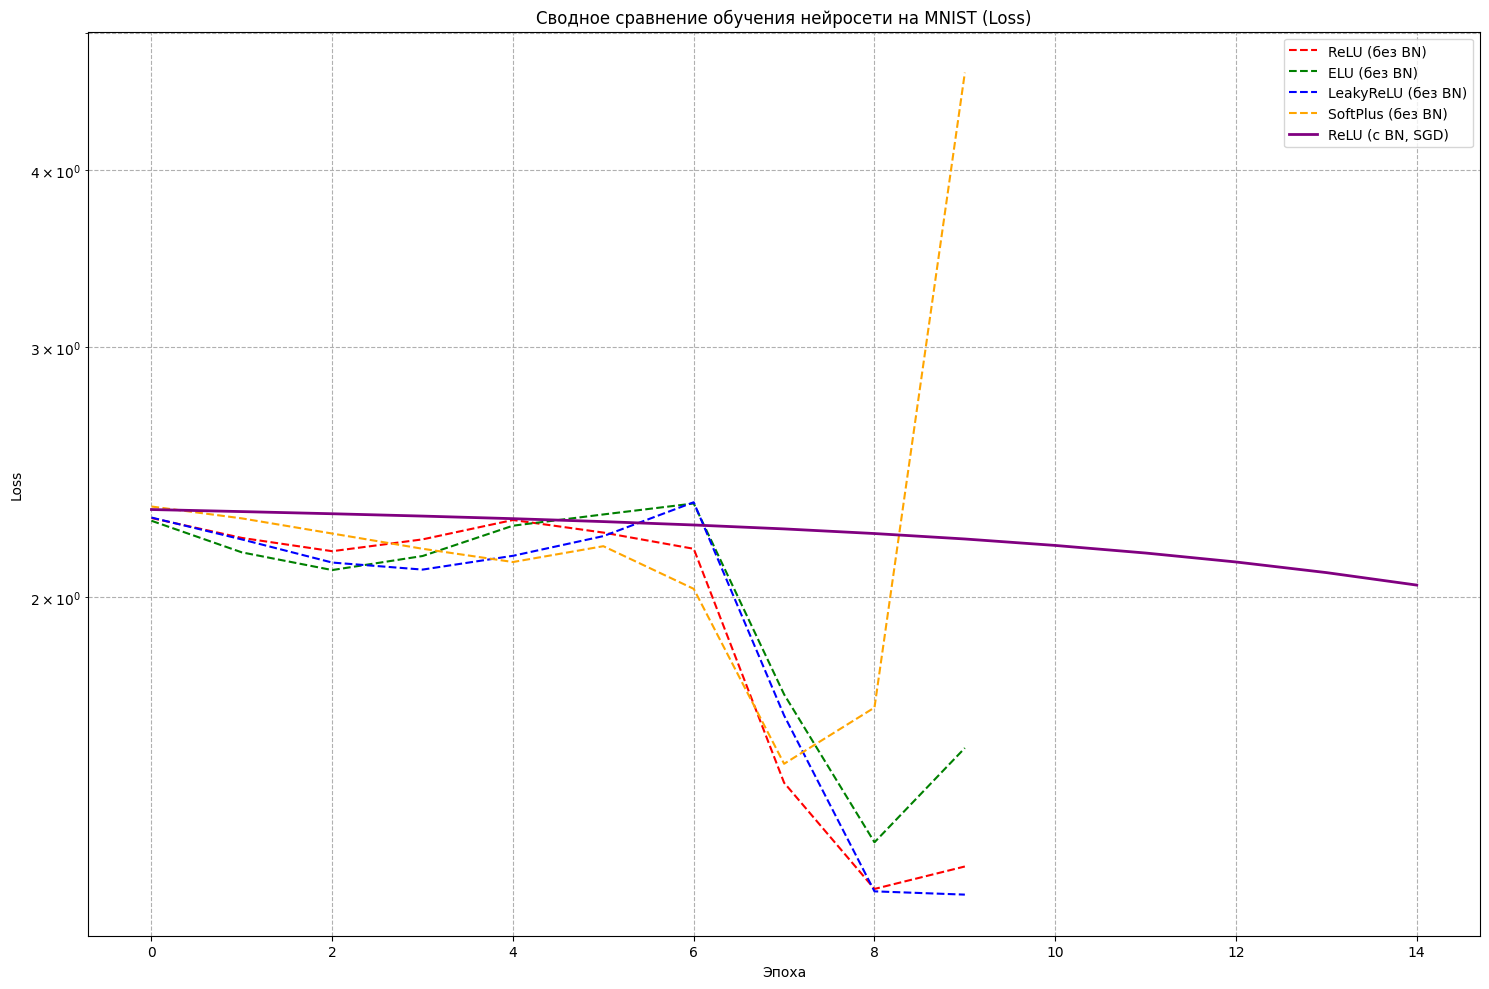

In [142]:
def clean_losses(losses):
    cleaned_losses = [loss for loss in losses if np.isfinite(loss)]
    return cleaned_losses

losses_relu_cleaned = clean_losses(losses_relu)
losses_elu_cleaned = clean_losses(losses_elu)
losses_leaky_cleaned = clean_losses(losses_leaky)
losses_softplus_cleaned = clean_losses(losses_softplus)
losses_with_bn_cleaned = clean_losses(losses_with_bn)
losses_no_bn_cleaned = clean_losses(losses_no_bn)

plt.figure(figsize=(15, 10))

plt.plot(losses_relu_cleaned, label='ReLU (без BN)', color='red', linestyle='--')
plt.plot(losses_elu_cleaned, label='ELU (без BN)', color='green', linestyle='--')
plt.plot(losses_leaky_cleaned, label='LeakyReLU (без BN)', color='blue', linestyle='--')
plt.plot(losses_softplus_cleaned, label='SoftPlus (без BN)', color='orange', linestyle='--')

plt.plot(losses_with_bn_cleaned, label='ReLU (с BN, SGD)', color='purple', linewidth=2)

plt.title("Сводное сравнение обучения нейросети на MNIST (Loss)")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

SoftPlus очень чувствительна и нестабильна при данных параметрах обучения. Даже при lr=1e-4 она не смогла поддерживать стабильный процесс сходимости

BN обеспечивает высочайшую стабильность (график не скачет), но для получения максимальной производительности нужно подбирать темп обучения индивидуально для каждой конфигурации.

ELU и LeakyReLU — самые эффективные активации в данном случае.

In [143]:
def build_net_with_bn():
    net = Sequential()
    net.add(Linear(784, 128))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(128))
    net.add(ReLU())
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

optimizer_config_adam = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}

n_epochs_adam = 15

losses_adam = train_and_get_loss_history(
    build_net_with_bn,
    'С BatchNorm, Adam',
    adam_optimizer,
    optimizer_config_adam,
    n_epoch=n_epochs_adam
)

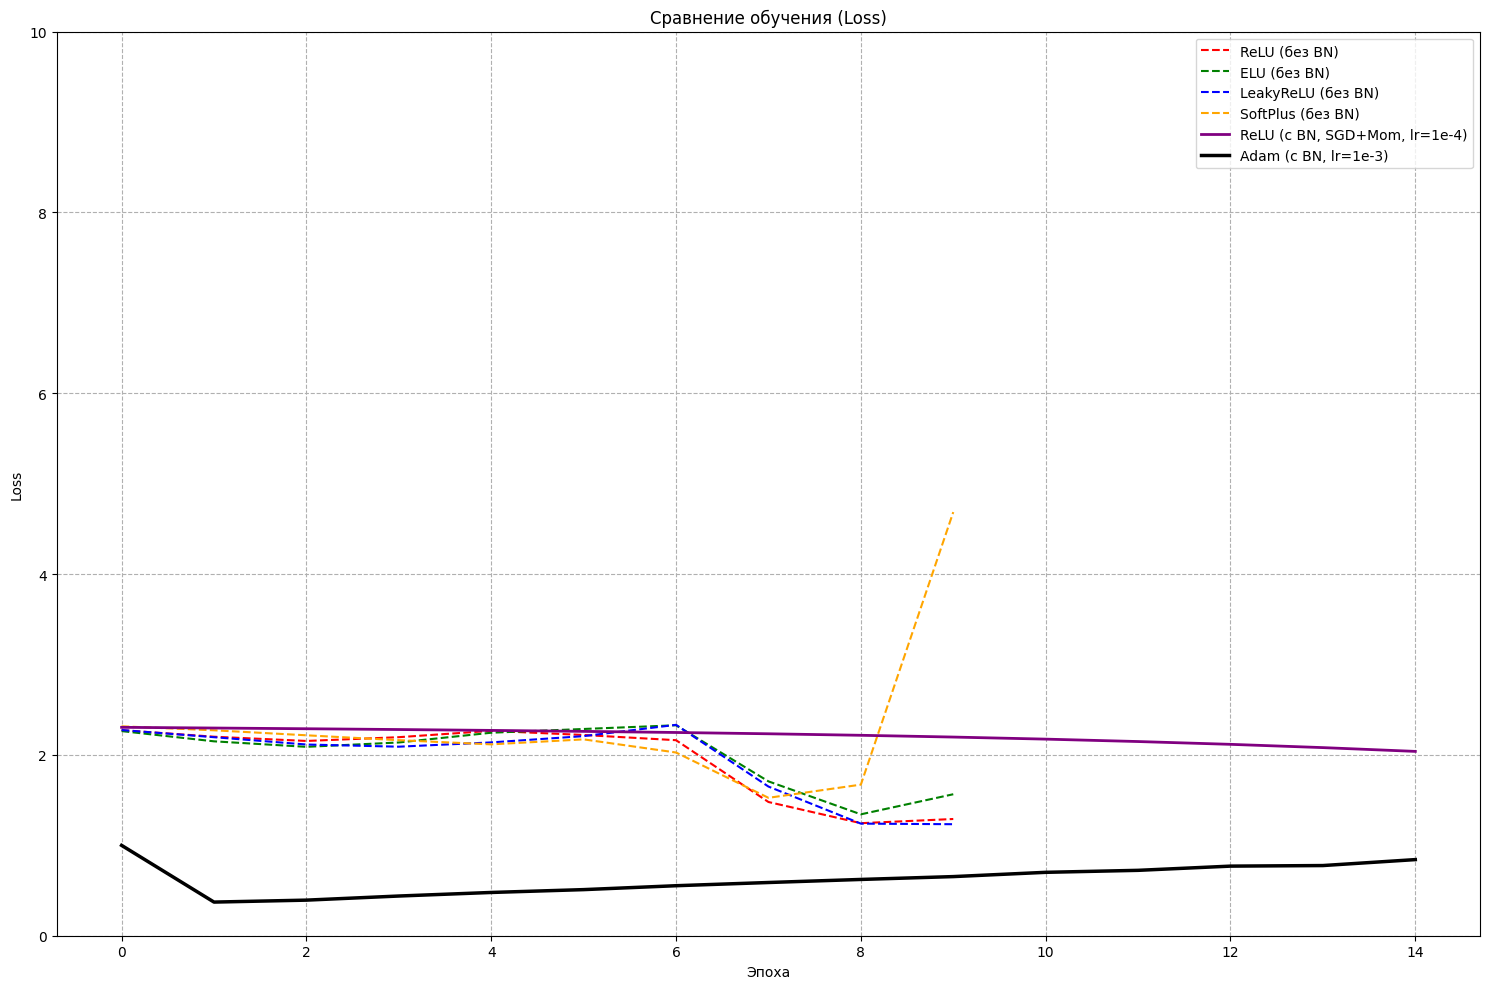

In [144]:
plt.figure(figsize=(15, 10))

plt.plot(losses_relu_cleaned, label='ReLU (без BN)', color='red', linestyle='--')
plt.plot(losses_elu_cleaned, label='ELU (без BN)', color='green', linestyle='--')
plt.plot(losses_leaky_cleaned, label='LeakyReLU (без BN)', color='blue', linestyle='--')
plt.plot(losses_softplus_cleaned, label='SoftPlus (без BN)', color='orange', linestyle='--')

plt.plot(losses_with_bn_cleaned, label='ReLU (с BN, SGD+Mom, lr=1e-4)', color='purple', linewidth=2)

plt.plot(losses_adam_cleaned, label='Adam (с BN, lr=1e-3)', color='black', linewidth=2.5)


plt.title("Сравнение обучения (Loss)")
plt.xlabel("Эпоха")
plt.ylabel("Loss")

plt.ylim(0, 10)

plt.legend(loc='upper right')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

Adam достиг потери 0.372 на второй эпохе; SGD+Momentum достиг потери около 2.001 на пятнадцатой эпохе (при LR 1e-4).
Adam сходится гораздо быстрее и достигает значительно лучшего уровня потерь, чем SGD+Momentum, что подтверждает его высокую эффективность.

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Для большинства задач ReLU или LeakyReLU — это лучший выбор по умолчанию из-за их скорости. ELU стоит использовать, когда требуется максимальная точность и стабильность в глубоких моделях, а дополнительные вычисления приемлемы.

Помогает ли BatchNormalization?
Да. BN делает процесс оптимизации более предсказуемым и менее "скачущим". BN позволяет использовать значительно более высокие темпы обучения. Без BN сеть мгновенно "взрывается" астрономическими потерями. С BN сеть остается стабильной и управляемой.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Print here your accuracy on test set. It should be around 90%.

In [145]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import scipy as sp
import scipy.signal

def load_dataset(flatten=False):
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    y = y.astype(int)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)
    X_train = X_train.astype(np.float32) / 255.0
    X_val = X_val.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0
    if flatten:
        X_train = X_train.reshape([-1, 28**2])
        X_val = X_val.reshape([-1, 28**2])
        X_test = X_test.reshape([-1, 28**2])
    return X_train, y_train, X_val, y_val, X_test, y_test

def one_hot_encode(labels, num_classes=10):
    encoded_labels = np.zeros((labels.shape[0], num_classes))
    encoded_labels[np.arange(labels.shape[0]), labels] = 1.0
    return encoded_labels

def get_batches(dataset, batch_size):
    X, y = dataset
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_indices = indices[start:end]
        yield X[batch_indices], y[batch_indices]

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

Y_train = one_hot_encode(y_train, 10)
Y_val = one_hot_encode(y_val, 10)
Y_test = one_hot_encode(y_test, 10)

def train_model(model_net, n_epoch, batch_size, optimizer_func, optimizer_config):

    criterion = ClassNLLCriterion()
    optimizer_state = {}

    loss_history = []
    accuracy_history = []

    print(f"Старт обучения на {n_epoch} эпох с {optimizer_func.__name__}")

    for epoch in range(n_epoch):
        epoch_losses = []

        model_net.training = True

        for x_batch, y_batch_onehot in get_batches((X_train, Y_train), batch_size):
            model_net.zeroGradParameters()

            # Forward pass
            predictions = model_net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch_onehot)

            # Backward pass
            dp = criterion.backward(predictions, y_batch_onehot)
            model_net.backward(x_batch, dp)

            # Update weights
            optimizer_func(model_net.getParameters(), model_net.getGradParameters(), optimizer_config, optimizer_state)

            epoch_losses.append(loss)

        mean_epoch_loss = np.mean(epoch_losses)
        loss_history.append(mean_epoch_loss)

        model_net.training = False

        val_predictions = model_net.forward(X_val)

        val_accuracy = np.mean(np.argmax(val_predictions, axis=1) == y_val)
        accuracy_history.append(val_accuracy)

        print(f"Эпоха {epoch+1}/{n_epoch}, Loss: {mean_epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return model_net, loss_history, accuracy_history

def build_mlp_model():
    net = Sequential()
    net.add(Linear(784, 256))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(256))
    net.add(ReLU())
    net.add(Linear(256, 128))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(128))
    net.add(ReLU())
    net.add(Dropout(p=0.2))
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    return net

optimizer_config_adam = {
    'learning_rate': 0.0001,
    'beta1': 0.9,
    'beta2': 0.999,
    'epsilon': 1e-8
}

N_EPOCHS = 15

model_final, loss_history, accuracy_history = train_model(
    build_mlp_model(),
    n_epoch=N_EPOCHS,
    batch_size=BATCH_SIZE,
    optimizer_func=adam_optimizer,
    optimizer_config=optimizer_config_adam
)

model_final.training = False

predictions_test = model_final.forward(X_test)
predicted_classes_test = np.argmax(predictions_test, axis=1)

true_classes_test = y_test
accuracy_test = np.mean(predicted_classes_test == true_classes_test)

print(f"\nФинальная точность модели на тестовом наборе: {accuracy_test * 100:.2f}%")

Старт обучения на 15 эпох с adam_optimizer
Эпоха 1/15, Loss: 2.1307, Val Accuracy: 0.8405
Эпоха 2/15, Loss: 1.6827, Val Accuracy: 0.9048
Эпоха 3/15, Loss: 1.1216, Val Accuracy: 0.9295
Эпоха 4/15, Loss: 0.6340, Val Accuracy: 0.9432
Эпоха 5/15, Loss: 0.3688, Val Accuracy: 0.9531
Эпоха 6/15, Loss: 0.2464, Val Accuracy: 0.9627
Эпоха 7/15, Loss: 0.1805, Val Accuracy: 0.9676
Эпоха 8/15, Loss: 0.1432, Val Accuracy: 0.9702
Эпоха 9/15, Loss: 0.1186, Val Accuracy: 0.9706
Эпоха 10/15, Loss: 0.1022, Val Accuracy: 0.9724
Эпоха 11/15, Loss: 0.0900, Val Accuracy: 0.9722
Эпоха 12/15, Loss: 0.0775, Val Accuracy: 0.9743
Эпоха 13/15, Loss: 0.0718, Val Accuracy: 0.9742
Эпоха 14/15, Loss: 0.0653, Val Accuracy: 0.9750
Эпоха 15/15, Loss: 0.0593, Val Accuracy: 0.9727

Финальная точность модели на тестовом наборе: 97.35%


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [146]:
# Your beautiful code here.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

def load_dataset_torch():
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long) # Метки классов для CrossEntropyLoss
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    from torch.utils.data import TensorDataset, DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    return train_dataset, val_dataset, test_dataset

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def train_pytorch_model(model, train_loader, val_loader, n_epoch, optimizer_config):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=optimizer_config['learning_rate'])

    print(f"\nСтарт обучения PyTorch модели на {n_epoch} эпох")

    for epoch in range(n_epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        model.eval()
        val_accuracy = 0
        with torch.no_grad():
            correct = 0
            total = 0
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            val_accuracy = 100 * correct / total

        print(f"Эпоха {epoch+1}/{n_epoch}, Val Accuracy: {val_accuracy:.2f}%")

    return model

train_dataset, val_dataset, test_dataset = load_dataset_torch()

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

optimizer_config_adam_torch = {
    'learning_rate': 0.001
}

pytorch_model = MLP()
pytorch_model_final = train_pytorch_model(pytorch_model, train_loader, val_loader, 10, optimizer_config_adam_torch)

pytorch_model_final.eval()
test_accuracy = 0
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        output = pytorch_model_final(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    test_accuracy = 100 * correct / total

print(f"\nФинальная точность PyTorch модели на тестовом наборе: {test_accuracy:.2f}%")



Старт обучения PyTorch модели на 10 эпох
Эпоха 1/10, Val Accuracy: 96.88%
Эпоха 2/10, Val Accuracy: 97.66%
Эпоха 3/10, Val Accuracy: 97.66%
Эпоха 4/10, Val Accuracy: 97.85%
Эпоха 5/10, Val Accuracy: 97.91%
Эпоха 6/10, Val Accuracy: 98.03%
Эпоха 7/10, Val Accuracy: 97.85%
Эпоха 8/10, Val Accuracy: 98.07%
Эпоха 9/10, Val Accuracy: 98.04%
Эпоха 10/10, Val Accuracy: 98.06%

Финальная точность PyTorch модели на тестовом наборе: 97.97%
